In [1]:
import graph as gr
import numpy as np
import networkx as nx

import torch
torch.manual_seed(12121998)
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models import basic_gnn as torch_models

import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Creating Dataset

In [2]:
# Macros

NORMALIZE_TARGET_FLAG = True # normalize output between 0 and 1!

COORDINATES_FEATURE_FLAG = True # If true also position is used as feature!

In [3]:
# FILENAMES AND FILEPATH

# mesh name
mesh_filename = "simple_laplacian_mesh"

## target filepaths
target_filepaths = ["../mesh/simple_laplacian_u.txt"] # you can add other targets

## feature filepaths 
feature_filepaths = ["../mesh/simple_laplacian_f.txt"]

In [4]:
folder = gr.import_mesh(mesh_filename)

loaded_graph = gr.build_graph(folder)

loaded_adj = gr.build_adjacency(loaded_graph, folder)

loaded_targets = [torch.tensor(0)] * len(target_filepaths)
for i, data in enumerate(target_filepaths):
    loaded_targets[i] = torch.tensor(gr.import_features(data)).double()

loaded_features = [torch.tensor(0)] * len(feature_filepaths)
for i, data in enumerate(feature_filepaths):
    loaded_features[i] = torch.tensor(gr.import_features(data)).double()


if NORMALIZE_TARGET_FLAG:
    u_max = [-1] * len(loaded_targets)
    u_min = [-1] * len(loaded_targets)
    for i, data in enumerate(loaded_targets):
        u_max[i] = data.max()
        u_min[i] = data.min()
        loaded_targets[i] = (data - u_min[i]) / (u_max[i] - u_min[i])  


TOT_SAMPLES = loaded_targets[0].shape[1]

In [5]:
## Creating torch DATASET (see torch_geometric.data)

# will be used to create the complete dataset
data_list = [torch.tensor(0)] * TOT_SAMPLES

# INITIALIZING COMMON PROPERTIES TO ALL GRAPHS

# Graph connectivity (# use t().contiguous() ...)
edge_index = torch.tensor([ [i,j] for i in range(loaded_adj.shape[0]) for j in range(loaded_adj.shape[1]) if loaded_adj[i,j]>0 ])

# Node position matrix ( ACTUALLY, IT SHOULD NOT BE NEEDED SINCE IT'S CONSTANT ... )
# check whether pos is used in the training or not. In the second case it's useless for dynamic meshes
pos = torch.hstack( (
                        torch.unsqueeze(torch.tensor(list(nx.get_node_attributes(loaded_graph, 'x').values())), 1 ),
                        torch.unsqueeze(torch.tensor(list(nx.get_node_attributes(loaded_graph, 'y').values())), 1 ) 
                    )
                  ).double()

# INITIALIZING THE DIFFERENT GRAPHS

for t in range(TOT_SAMPLES):
    
    ## Node feature matrix
    
    # first feature (type of node)
    x = torch.unsqueeze(torch.tensor(list(nx.get_node_attributes(loaded_graph, 'n').values())), 1).double()
    
    # other features (forcing f values)
    [x := torch.hstack((x, loaded_features[j][:, t][:, None])) for j in range(len(loaded_features))]
    
    if COORDINATES_FEATURE_FLAG:
        torch.hstack((x, pos))
    
    ## Node-level ground-truth labels (heat)
    
    
    # first feature (pression or velocity or ...)
    y = loaded_targets[0][:, t][:, None]
    
    # other features (pression, velocities, ...)
    [y := torch.hstack((y, loaded_targets[j][:, t][:, None])) for j in range(1,len(loaded_targets))]

    data_list[t] = Data(x=x, edge_index=edge_index.t().contiguous(), y=y, pos=pos)

In [6]:
batch_size_data = 32
dataloader = DataLoader(data_list, batch_size = batch_size_data, shuffle = True)

# Model

In [7]:
# class GCN(torch.nn.Module):
    
#     def __init__(self):
#         super().__init__()
#         self.conv1 = GCNConv(dataloader.dataset[0].num_node_features, 2)
#         self.conv2 = GCNConv(2, 1)


#     def forward(self, x, edge_index):
#      
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = self.conv2(x, edge_index)
#         x = F.tanh(x)

#         return x

# model = GCN().double()

In [8]:
model = torch_models.GAT(
    in_channels = dataloader.dataset[0].num_node_features,
    hidden_channels=2,
    num_layers=2,
    out_channels=1,
    act = "relu"
    ).double()

In [9]:
learning_rate = 1e-3

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss = 0
    for batch, data in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(data.x, data.edge_index)
        loss = loss_fn(pred, data.y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss += loss.item()
    print(f"loss: {loss/len(dataloader):>7f}")

In [11]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.767800
Epoch 2
-------------------------------
loss: 0.627984
Epoch 3
-------------------------------
loss: 0.351274
Epoch 4
-------------------------------
loss: 0.139380
Epoch 5
-------------------------------
loss: 0.153643
Epoch 6
-------------------------------
loss: 0.055991
Epoch 7
-------------------------------
loss: 0.032418
Epoch 8
-------------------------------
loss: 0.024554
Epoch 9
-------------------------------
loss: 0.016364
Epoch 10
-------------------------------
loss: 0.005643
Epoch 11
-------------------------------
loss: 0.006368
Epoch 12
-------------------------------
loss: 0.003830
Epoch 13
-------------------------------
loss: 0.004267
Epoch 14
-------------------------------
loss: 0.004291
Epoch 15
-------------------------------
loss: 0.003812
Epoch 16
-------------------------------
loss: 0.003516
Epoch 17
-------------------------------
loss: 0.003633
Epoch 18
-------------------------------
loss: 0.003746
E

In [16]:
pred = (model(dataloader.dataset[0]['x'], dataloader.dataset[0]['edge_index']) ) * (u_max[0] - u_min[0]) + u_min[0]
pred = torch.tensor(pred[:, 0])
print(pred)

tensor([0.8563, 0.8563, 0.8745,  ..., 1.8886, 1.9393, 1.9863],
       dtype=torch.float64)


/tmp/ipykernel_2600/954662877.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(pred[:, 0])


In [13]:
true = (data_list[0].y) * (u_max[0] - u_min[0]) + u_min[0]
true= torch.tensor(true[:, 0])
print(true)

tensor([1.0000, 1.0000, 1.0001,  ..., 1.9120, 1.9546, 2.0000],
       dtype=torch.float64)


/tmp/ipykernel_2600/3483393236.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true= torch.tensor(true[:, 0])


In [14]:
error = abs(true - pred)
print(error)
print(error.min(), error.max())



tensor([0.1437, 0.1437, 0.1438,  ..., 0.1786, 0.1729, 0.1726],
       dtype=torch.float64)
tensor(0.0035, dtype=torch.float64) tensor(0.3805, dtype=torch.float64)


torch.Size([1089]) torch.Size([1089]) torch.Size([1089])


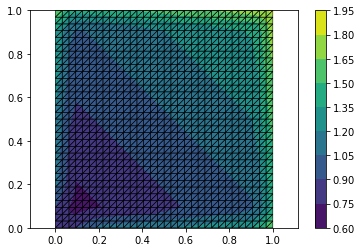

In [15]:
# plots a finite element mesh
def plot_fem_mesh(nodes_x, nodes_y, elements):
    for element in elements:
        x = [nodes_x[element[i]] for i in range(len(element))]
        y = [nodes_y[element[i]] for i in range(len(element))]
        plt.fill(x, y, edgecolor='black', fill=False, linewidth='0.5')

# FEM data
nodes_x = dataloader.dataset[0]['pos'][:,0]
nodes_y = dataloader.dataset[0]['pos'][:,1]
nodal_values = pred # loaded_features[0][:, 0]
elements = np.load(folder+"/triangles.npy")
triangulation = tri.Triangulation(nodes_x, nodes_y, elements)
print(nodes_x.size(), nodes_y.size(), nodal_values.size())

# plot the contours
plt.tricontourf(triangulation,  nodal_values)

# plot the finite element mesh
plot_fem_mesh(nodes_x, nodes_y, elements)

# show
plt.colorbar()
plt.axis('equal')
plt.show()